# Geometric Analysis of Sycophancy Activations

This notebook analyzes the geometry of activations extracted from the 2x2 factorial experiment:

**Factors:**
1. **User Persona**: Liberal vs. Conservative
2. **Model Agreement**: Agree (Sycophantic) vs. Disagree (Non-Sycophantic)

**Goal:**
- Isolate the **Sycophancy Vector** (difference between Agree and Disagree, controlling for token identity).
- Analyze if this vector is orthogonal to the **Partisanship Vector** (Liberal vs. Conservative).
- Visualize the geometry in high-dimensional space.
- **Verification:** Perform Cross-Probe Analysis to confirm disentanglement at Layer 30 vs Layer 21.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

In [18]:
import sys
import numpy as np
# --- COMPATIBILITY PATCH ---
# Fix for loading NumPy 2.0+ saved files on NumPy 1.x systems
try:
    import numpy._core
except ImportError:
    if hasattr(np, 'core'):
        sys.modules['numpy._core'] = np.core
        print("Patched numpy._core for compatibility.")

In [19]:
# Load Data
# REPLACE WITH YOUR PATH to full extraction
file_path = "../results/activations_full.npz" 
# Fallback to pilot if full not found
import os
if not os.path.exists(file_path):
    print("Full dataset not found, using pilot...")
    file_path = "../results/activation_100.npz"

data = np.load(file_path, allow_pickle=True)

metadata = data['metadata']
if metadata.shape == (): metadata = metadata.item()

layers = data['layers']
print(f"Loaded {len(layers)} layers.")
print(f"Sample Metadata: {metadata[0]}")

Full dataset not found, using pilot...
Loaded 32 layers.
Sample Metadata: {'question_id': 'd7ba181d8bef0f66f2c097c37c94b4d1', 'condition': 'A', 'persona': 'liberal', 'agreement': 'agree', 'target_token': ' (A)'}


## 1. Define Conditions and Labels
We group indices by the 4 conditions and create labels for probing.

In [20]:
conditions = np.array([m['condition'] for m in metadata])
personas = np.array([m['persona'] for m in metadata])
agreements = np.array([m['agreement'] for m in metadata])

idx_A = np.where(conditions == 'A')[0] # Lib Persona, Agree
idx_B = np.where(conditions == 'B')[0] # Lib Persona, Disagree
idx_C = np.where(conditions == 'C')[0] # Con Persona, Agree
idx_D = np.where(conditions == 'D')[0] # Con Persona, Disagree

print(f"Counts: A={len(idx_A)}, B={len(idx_B)}, C={len(idx_C)}, D={len(idx_D)}")

# Labels for Probes
# Sycophancy: Agree (1) vs Disagree (0)
y_syco = (agreements == 'agree').astype(int)

# Partisanship: Liberal (1) vs Conservative (0)
y_party = (personas == 'liberal').astype(int)

print(f"Sycophancy Labels: {np.bincount(y_syco)}")
print(f"Partisanship Labels: {np.bincount(y_party)}")

Counts: A=25, B=25, C=25, D=25
Sycophancy Labels: [50 50]
Partisanship Labels: [50 50]


## 2. Geometric Analysis: Signal Strength & Orthogonality
We calculate the Sycophancy Vector and its norm per layer.

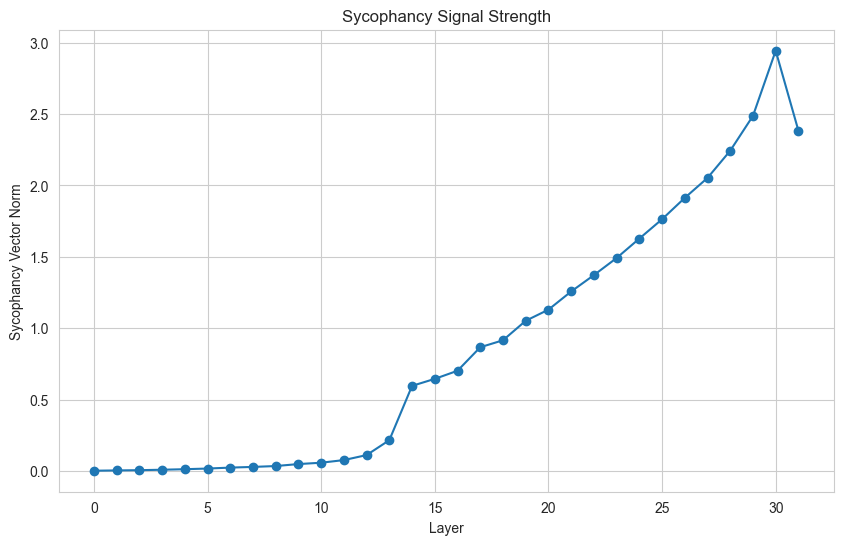

Best Sycophancy Layer: 30
Best Partisanship Layer: 30


In [21]:
sycophancy_norms = []
best_layer = -1
max_norm = 0
sycophancy_vectors = {}
partisanship_vectors = {}

for layer in layers:
    if f"layer_{layer}" not in data: continue
    acts = data[f"layer_{layer}"]
    if acts.dtype == 'object': acts = np.vstack(acts).astype(np.float32)
    
    mu_A = acts[idx_A].mean(axis=0)
    mu_B = acts[idx_B].mean(axis=0)
    mu_C = acts[idx_C].mean(axis=0)
    mu_D = acts[idx_D].mean(axis=0)
    
    # Sycophancy Vector: (Agree - Disagree)
    v_syco = (mu_A + mu_C)/2 - (mu_B + mu_D)/2
    
    # Partisanship Vector: (Lib - Con)
    v_party = (mu_A + mu_B)/2 - (mu_C + mu_D)/2
    
    norm = np.linalg.norm(v_syco)
    sycophancy_norms.append(norm)
    sycophancy_vectors[layer] = v_syco
    partisanship_vectors[layer] = v_party

    if norm > max_norm:
        max_norm = norm
        best_layer = layer

plt.plot(layers, sycophancy_norms, marker='o')
plt.xlabel("Layer")
plt.ylabel("Sycophancy Vector Norm")
plt.title("Sycophancy Signal Strength")
plt.show()
print(f"Best Sycophancy Layer: {best_layer}")

# Also calculate Partisanship norms to find its peak
party_norms = [np.linalg.norm(partisanship_vectors[l]) for l in layers]
best_party_layer = layers[np.argmax(party_norms)]
print(f"Best Partisanship Layer: {best_party_layer}")

## 3. Cross-Probe Verification Experiment
**Hypothesis:**
- At **Layer 21** (Old Method's peak), Sycophancy and Partisanship are **entangled** (correlated predictions).
- At **Layer 30** (New Method's peak), Sycophancy and Partisanship are **disentangled** (orthogonal/uncorrelated).

**Method:**
1. Train Logistic Regression probe for Sycophancy ($P_{syco}$).
2. Train Logistic Regression probe for Partisanship ($P_{party}$).
3. Compare their predictions on held-out test set.

In [22]:
def train_and_evaluate_probes(layer_idx, acts, y_s, y_p):
    # Split data
    X_train, X_test, ys_train, ys_test, yp_train, yp_test = train_test_split(
        acts, y_s, y_p, test_size=0.3, random_state=42
    )
    
    # Use Pipeline with Scheduler to handle scaling issues
    # Train Sycophancy Probe
    clf_syco = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)).fit(X_train, ys_train)
    acc_syco = clf_syco.score(X_test, ys_test)
    probs_syco = clf_syco.predict_proba(X_test)[:, 1]
    
    # Train Partisanship Probe
    clf_party = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000)).fit(X_train, yp_train)
    acc_party = clf_party.score(X_test, yp_test)
    probs_party = clf_party.predict_proba(X_test)[:, 1]
    
    # Correlation between probe predictions (logits/probs)
    # If concepts are entangled, knowing one predicts the other.
    corr = np.corrcoef(probs_syco, probs_party)[0, 1]
    
    # Cosine similarity of weight vectors (extract from pipeline)
    w_syco = clf_syco.named_steps['logisticregression'].coef_.flatten()
    w_party = clf_party.named_steps['logisticregression'].coef_.flatten()
    cos_sim = np.dot(w_syco, w_party) / (np.linalg.norm(w_syco) * np.linalg.norm(w_party) + 1e-9)
    
    return acc_syco, acc_party, corr, cos_sim

layers_to_test = [21, best_layer] # Compare L21 vs L30

print(f"{'Layer':<6} | {'Syco Acc':<10} | {'Party Acc':<10} | {'Pred Corr':<10} | {'Vec Cos':<10}")
print("-"*60)

for l in layers_to_test:
    if f"layer_{l}" not in data: continue
    acts = data[f"layer_{l}"]
    if acts.dtype == 'object': acts = np.vstack(acts).astype(np.float32)
    
    acc_s, acc_p, corr, vec_cos = train_and_evaluate_probes(l, acts, y_syco, y_party)
    print(f"{l:<6} | {acc_s:<10.4f} | {acc_p:<10.4f} | {corr:<10.4f} | {vec_cos:<10.4f}")


Layer  | Syco Acc   | Party Acc  | Pred Corr  | Vec Cos   
------------------------------------------------------------
21     | 0.6000     | 0.9333     | 0.1888     | -0.0032   
30     | 0.4667     | 1.0000     | 0.2686     | 0.0474    


/Users/aryamanbahl/miniconda3/envs/abs_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/aryamanbahl/miniconda3/envs/abs_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/aryamanbahl/miniconda3/envs/abs_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/aryamanbahl/miniconda3/envs/abs_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/aryamanbahl/miniconda3/envs/abs_env/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: ov

## 4. Interpretation

- **High Prediction Correlation / Vector Cosine** at Layer 21 supports the "Entanglement Hypothesis" (Old method was measuring a mix).
- **Low Prediction Correlation / Vector Cosine** at Layer 30 supports the "Disentanglement/Orthogonality Hypothesis" (New method is clean).
- **Accuracies:** We expect high accuracy for both probes at their respective responsive layers, but they should be *independent* at Layer 30.